### A_B_test

AБ-тест по внедрению функционала, который после клика на кнопку “Я не знаю размер” либо:
- показывает калькулятор для подбора размера колец (А), 
- либо просто таблицу размеров (Б). 
- 10 - калькулятор, 90 -просто таблица размеров

смотрим на количество добавлений в корзину  и на сумму товаров добавленных в корзину, значит надо смотреть на метрики среднего по вариантам : 
- СРЕДНЕЕ количество заказов в корзине и
- СРЕДНЯЯ сумма заказов в корзине, особенна интересна, т.к. деньги

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as stm 

In [2]:
df = pd.read_csv('./Data/Ювелирный магазин, данные.csv')

df.columns = ['date', 'var', 'count_add_cart', 'sum_add_cart']
df['var'] = np.where(df['var'] == 10, 'A', 'B')
df['date'] = pd.to_datetime(df.date)
df.head(3)

,date,var,count_add_cart,sum_add_cart
0,2019-09-01,B,56,110247
1,2019-09-01,A,52,163098
2,2019-09-02,A,59,93317


### 1 .  Для начала отборазим то, что имеем - графики метрик по группам + метрики

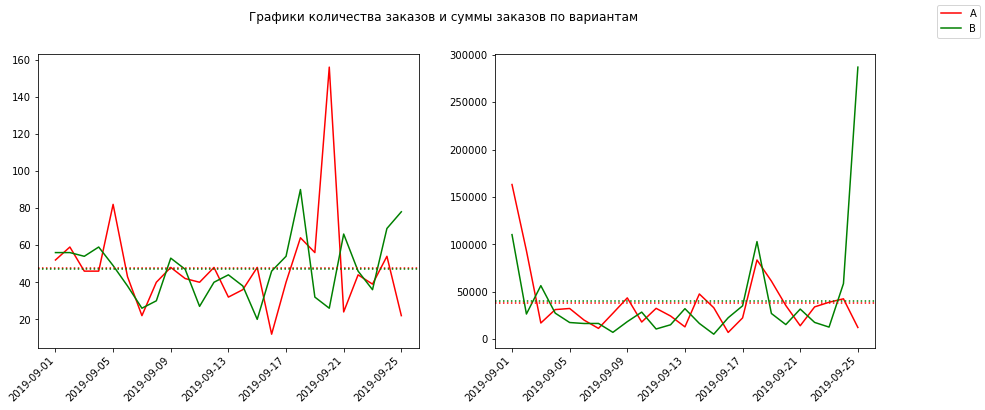

In [3]:
df_group = df.groupby(['var', 'date']).agg({'count_add_cart' : 'sum', 'sum_add_cart' : 'sum'})

fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].plot(df_group.loc['A'].count_add_cart, label='A', color='r')
ax[0].plot(df_group.loc['B'].count_add_cart, label='B', color='g')
ax[0].axhline(df_group.loc['A'].count_add_cart.mean(),linestyle = ':', color='r')
ax[0].axhline(df_group.loc['B'].count_add_cart.mean(),linestyle = ':', color='g')

ax[1].plot(df_group.loc['A'].sum_add_cart, label='A', color='r')
ax[1].plot(df_group.loc['B'].sum_add_cart, label='B', color='g')
ax[1].axhline(df_group.loc['A'].sum_add_cart.mean(),linestyle = ':', color='r')
ax[1].axhline(df_group.loc['B'].sum_add_cart.mean(),linestyle = ':', color='g')

fig.suptitle('Графики количества заказов и суммы заказов по вариантам')
fig.legend(['A', 'B'])
fig.autofmt_xdate(rotation=45);

In [4]:
# посмотрим Статистики целевых метрик по вариантам
df.groupby('var').agg({'count_add_cart' :['sum', 'mean'], 'sum_add_cart' :['sum', 'mean']})

# df.groupby('var')[['count_add_cart', 'sum_add_cart']].describe() # или так

count_add_cart       sum_add_cart          
               sum  mean          sum      mean
var                                            
A             1195  47.8       958822  38352.88
B             1180  47.2      1015053  40602.12

- Среднее количество заказов и общее количество заказов почти одинаковы 
- Средняя и общая суммы заказов в В варианте на 5 процентов выше
- Можно предположить, что с точки зрения прибыли вариант В лучше чем А

### 2.  Есть ли статистически значимая разница между метриками по вариантам?

In [5]:
# 2.1
# группируем и создаем датафреймы по группам
df_group = df.groupby(['var', 'date']).agg({'count_add_cart' : 'sum', 'sum_add_cart' : 'sum'})
df_a = df_group.query('var == "A"')
df_b = df_group.query('var == "B"')

In [6]:
# 2.2
# Пытаемся использовать Доверительные Интервалы для оценки метрик, для этого
# строим графики и ДИ для метрик по вариантам и смотрим, что имеем

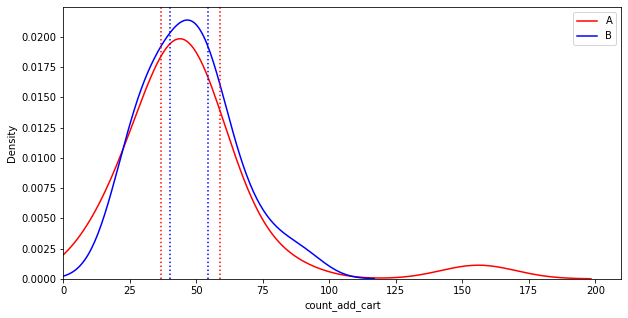

In [7]:
# 2.2.1
# count_add_cart + график + MeanCI

# доверительный интервал для среднего
import statsmodels.stats.api as stm

mci_count_a = stm.DescrStatsW(df_a['count_add_cart'].values).tconfint_mean(alpha=0.05, alternative='two-sided')
mci_count_b = stm.DescrStatsW(df_b['count_add_cart'].values).tconfint_mean(alpha=0.05)
# они поменяли: alpha = significance level for the confidence interval, was the confidence level, e.g. 0.95


import seaborn as sns

plt.figure(figsize=(10,5))
sns.kdeplot(df_a.count_add_cart, label='A', color='r')
sns.kdeplot(df_b.count_add_cart, label='B', color='b')

plt.axvline(mci_count_a[0], color='r', ls=':')
plt.axvline(mci_count_a[1], color='r', ls=':')
plt.axvline(mci_count_b[0], color='b', ls=':')
plt.axvline(mci_count_b[1], color='b', ls=':')
plt.xlim(left = 0)

plt.legend();

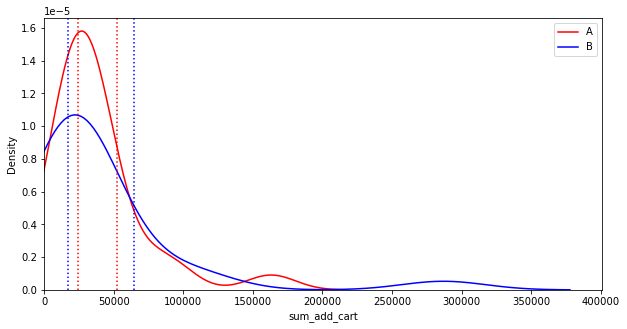

In [8]:
# 2.2.2
# sum_add_cart + график + MeanCI

mci_sum_a = stm.DescrStatsW(df_a['sum_add_cart'].values).tconfint_mean(alpha=0.05, alternative='two-sided')
mci_sum_b = stm.DescrStatsW(df_b['sum_add_cart'].values).tconfint_mean()

plt.figure(figsize=(10,5))
sns.kdeplot(df_a['sum_add_cart'], label='A', color='r')
sns.kdeplot(df_b['sum_add_cart'], label='B', color='b')

plt.axvline(mci_sum_a[0], color='r', ls=':')
plt.axvline(mci_sum_a[1], color='r', ls=':')
plt.axvline(mci_sum_b[0], color='b', ls=':')
plt.axvline(mci_sum_b[1], color='b', ls=':')
plt.xlim(left = 0)
plt.legend();

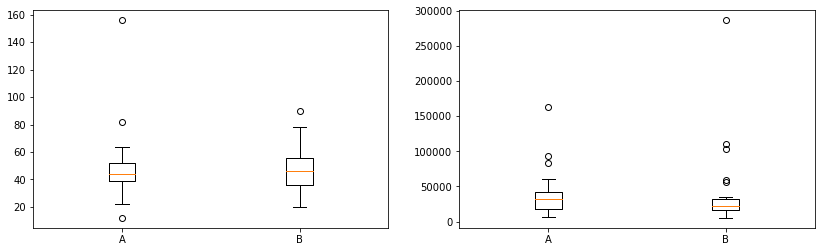

In [9]:
# 2.3
# посмотрим чуть иначе на данные

fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].boxplot([df_a.count_add_cart, df_b.count_add_cart], labels=['A', 'B'])
ax[1].boxplot([df_a.sum_add_cart, df_b.sum_add_cart], labels=['A', 'B']);

Очевидно, что распределения метрик НЕ нормальные и поэтому:
     - нельзя использовать метод сравнения ДИ
     - и нельзя использовать статистический тест (Paired t-test)

Значит на данный момент нельзя сделать вывод о различимости вариантов и, чтобы понять есть ли статистически ЗНАЧИМАЯ разница между вариантами A и B по метрикам СРЕДНЕГО количества покупок и СРЕДНЕЙ сумме покупок, то надо исследовать далее и использовать другие методы:
   - сначала просто бутстрап (т.к. не зависит от вида распределения)
             * распределение метрик + ДИ 
             * разности средних
   - затем сделаем проверку статистических гипотез, проверим
              через бутстрап и p-value
              ради интереса можно сделать t-test 

In [10]:
### 3

# 3.1
# попытаемся используя бутсрап смоделировать Генеральные Совокупности
# метрик, построим ДИ и посмотрим, что получилось

In [11]:
# Bootstrap для Генеральных Совокупностей

def boot_population(arr_1, arr_2, name_of_val, n=100):
    temp_a = []
    temp_b = []
    N = 3000
    n = min(n, len(arr_1))
    
    for i in range(N):
        arr_a = np.random.choice(arr_1, size=n, replace=True)
        arr_b = np.random.choice(arr_2, size=n, replace=True)
        
        temp_a.append(np.mean(arr_a))
        temp_b.append(np.mean(arr_b))
        
    # персентили
    q_temp_a = np.percentile(temp_a, [2.5, 97.5])
    q_temp_b = np.percentile(temp_b, [2.5, 97.5])
  
    # ДИ
    mci_a = stm.DescrStatsW(temp_a).tconfint_mean()
    mci_b = stm.DescrStatsW(temp_b).tconfint_mean()
    
    # гистограмма или kde
    plt.figure(figsize=(8,4))
    sns.kdeplot(temp_a, label='A', color='r')
    sns.kdeplot(temp_b, label='B', color='b')
    
    plt.axvline(q_temp_a[0], color='r', ls=':')
    plt.axvline(q_temp_a[1], color='r', ls=':')
    plt.axvline(q_temp_b[0], color='b', ls=':')
    plt.axvline(q_temp_b[1], color='b', ls=':')
    
    plt.title('Распределение для ' + str(name_of_val) + ' + ДИ' )
    plt.xlabel(name_of_val, fontsize=12)
    plt.legend();

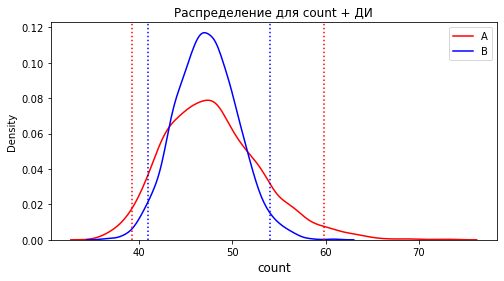

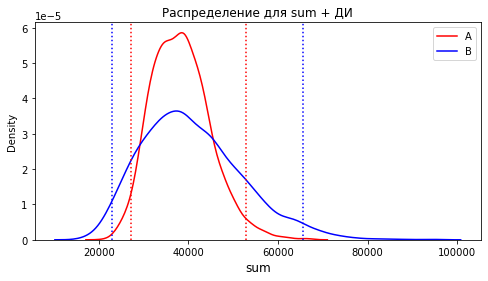

In [12]:
# отобразим
boot_population(df_a.count_add_cart, df_b.count_add_cart, 'count')
boot_population(df_a.sum_add_cart, df_b.sum_add_cart, 'sum')

Распределения приблизительно НОРМАЛЬНЫЕ и значит метод ДИ применим, но т.к ДИ пересекаются 
(расчитанные через персентили), то нельзя сделать вывод о различимости вариантов и значит смотрим дальше 
и делаем РАЗНИЦУ СРЕДНИХ значений метрик 

In [13]:
# 3.2
# РАЗНИЦА СРЕДНИХ значений метрик по вариантам

# для этого моделируем через Bootstrap РАЗНИЦЫ СРЕДНИХ значений метрик count и sum
# но сначала посмотрим на РАЗНИЦУ СРЕДНИХ по вариантам

print(df_b['count_add_cart'].mean() - df_a['count_add_cart'].mean())
print(df_b['sum_add_cart'].mean() - df_a['sum_add_cart'].mean())

-0.5999999999999943
2249.2400000000052


In [14]:
### statsmodels.stats.weightstats.DescrStatsW.ttest_mean
import statsmodels.stats.api as stm 

In [15]:
# Bootstrap для РАЗНИЦЫ СРЕДНИХ
 
def diff_foo(arr_1, arr_2, name_of_val, n=100):
    temp_diff = []
    N = 3000
    n = min(n, len(arr_1))
    
    for i in range(N):
        arr_a = np.mean(np.random.choice(arr_1, size=n, replace=True))
        arr_b = np.mean(np.random.choice(arr_1, size=n, replace=True))
        temp_diff.append(arr_b - arr_a)
        
    # центрируем
    temp_diff = temp_diff - np.mean(temp_diff)
    
    # разница средних изначальная
    diff_mean_origin = np.mean(arr_2) - np.mean(arr_1) # т.к. правосторонняя альтернатива
    
      
    # p-value
    p_value = np.mean(temp_diff > diff_mean_origin) # здесь нужна доля случаев
    print('p_value from bootstrap for ', name_of_val, ' = ', p_value)
    
    # ДИ
    percent = np.percentile(temp_diff, [2.5, 97.5])
    
    # MeanCI
    mci = stm.DescrStatsW(temp_diff).tconfint_mean()
    
    # гистограмма
    plt.figure(figsize=(14,4))
    #sns.displot(temp_diff)
    sns.histplot(temp_diff)
    plt.title('Гистограмма РАЗНИЦЫ средних для ' + str(name_of_val))
    plt.axvline(diff_mean_origin, color='r', label='Mean')
    plt.axvline(percent[0], color='g', ls='--', label='percent')
    plt.axvline(percent[1], color='g', ls='--')
    plt.axvline(mci[0], color='k', ls=':', label='mci')
    plt.axvline(mci[1], color='k', ls=':')
    plt.axvline(0, color='yellow', label='0')
    #plt.xlabel(name_of_val, fontsize=12)
    plt.legend();
    
    # t-test
    t_test = stm.DescrStatsW(temp_diff).ttest_mean(value=0, alternative = "larger") # т.к правосторонняя
    print('p_value from t-test for', name_of_val, ' = ', t_test[1])

p_value from bootstrap for  count  =  0.5266666666666666
p_value from t-test for count  =  0.499999999999999
p_value from bootstrap for  sum  =  0.408
p_value from t-test for sum  =  0.5000000000000003


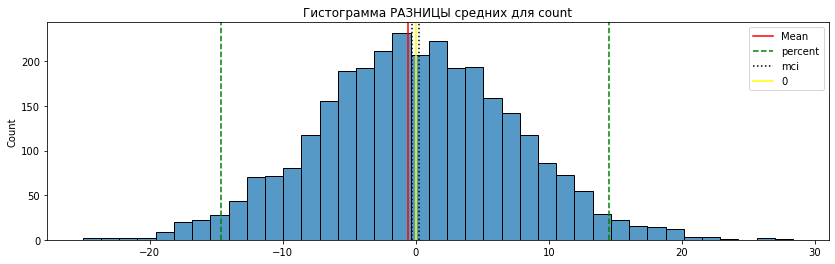

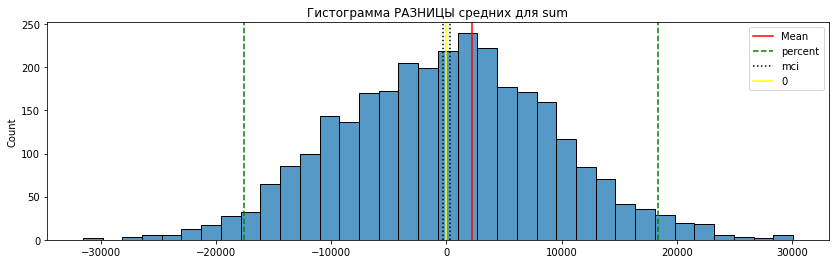

In [16]:
# соберем результаты и отобразим p-value по count и sum

diff_foo(df_a.count_add_cart, df_b.count_add_cart, 'count')
diff_foo(df_a.sum_add_cart, df_b.sum_add_cart, 'sum')

обе альтернативные гипотезы у нас были правосторонними
 - p_value_count = 0.533 > 0.05
 - p_value_sum = 0.407 > 0.05

### поэтому не отверагем нулевые гипотезы - т.е. варианты не отличаются в метриках

**плюс**

ДИ распределений РАЗНОСТЕЙ СРЕДНИХ обеих метрик (расчитанные двумя способами) включают в себя 0 - следовательно
можно утверждать, что **разница между вариантами отсутсвует** - т.е. А и Б варианты по среднему числу заказов и средней сумме заказа не различаются, а значит, использование калькулятора **не повлияло** на количество и на сумму заказов

### Вывод

использование калькулятора **не повлияло** на количество и на сумму заказов но учитывая, что деньги важнее, то предпочтительнее использовать В вариант,
(без калькулятора) т.к. в нем БОЛЬШЕ средняя сумма заказа, т.е. больше прибыль